In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar
import math
import h5py
from controllers.robot.cnn.models import BallAngleCNN



HDF5_SAVE_PATH = './controllers/robot/images.h5'

# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Parameters
height = 40
width = 200
n_samples = 2000  # Total samples (train + val + test)
n_test = math.ceil(n_samples * 0.1)
radius = 10
epochs = 20
val_ratio = 0.1  # 10% of training data for validation

field_of_view = 1.67  # radians

Using device: cuda


In [68]:
%reload_ext autoreload
%autoreload 2

In [78]:
def load_hdf5_data(hdf5_path, normalize=True):
    with h5py.File(hdf5_path, 'r') as hf:
        images = np.array(hf['camera_image'][:])  # Shape: (N, H, W, 4) [BGRA]
        angles = np.array(hf['angle'][:])
    images = images[..., :3]
    shuffled_indices = np.random.permutation(len(images))
    images = images[shuffled_indices]
    angles = angles[shuffled_indices]
    bgr_weights = [0.1140, 0.5870, 0.2989]
    images_gray = np.dot(images, bgr_weights)
    images = np.expand_dims(images_gray, axis=-1)  # Add channel dim back
    print(images.shape)
    if normalize:
        # Ensure data is float before dividing
        images = images.astype(np.float32) / 255.0

    return images, angles

In [79]:
X, y = load_hdf5_data(HDF5_SAVE_PATH)
batch_size = 256
n_test = math.ceil(len(X) * 0.1)
X_train_val, X_test = X[:-n_test], X[-n_test:]
y_train_val, y_test = y[:-n_test], y[-n_test:]

X_train_val_t = torch.tensor(
    X_train_val, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_val_t = torch.tensor(y_train_val, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_size = int((1 - val_ratio) * len(X_train_val_t))
val_size = len(X_train_val_t) - train_size
train_dataset, val_dataset = random_split(
    TensorDataset(X_train_val_t, y_train_val_t),
    [train_size, val_size]
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(
    X_test_t, y_test_t), batch_size=batch_size, shuffle=False)

(4965, 40, 200, 1)


In [80]:

model = BallAngleCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50

patience = 10  # Number of epochs to wait before stopping
min_delta = 0.001  # Minimum change to qualify as improvement
best_val_loss = float('inf')
counter = 0  # Counts epochs without improvement
early_stop = False

# Training loop with validation and early stopping
train_losses, val_losses = [], []

for epoch in range(epochs):
    if early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

    model.train()
    train_loss = 0.0
    progress_bar = tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for X_batch, y_batch in progress_bar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        progress_bar.set_postfix({"Train Loss": f"{loss.item():.4f}"})

    train_loss_avg = train_loss / len(train_loader)
    train_losses.append(train_loss_avg)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            val_loss += criterion(outputs, y_batch).item()

    val_loss_avg = val_loss / len(val_loader)
    val_losses.append(val_loss_avg)

    print(
        f"Epoch {epoch+1}, Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}")

    # Early stopping check
    if val_loss_avg + min_delta < best_val_loss:
        best_val_loss = val_loss_avg
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'controllers/robot/angle.pth')
    else:
        counter += 1
        if counter >= patience:
            early_stop = True

Epoch 1, Train Loss: 1.9602, Val Loss: 0.4248


Epoch 2, Train Loss: 0.4336, Val Loss: 0.4008


Epoch 3, Train Loss: 0.3349, Val Loss: 0.2436


Epoch 4, Train Loss: 0.2312, Val Loss: 0.1793


Epoch 5, Train Loss: 0.1734, Val Loss: 0.1355


Epoch 6, Train Loss: 0.1375, Val Loss: 0.1055


Epoch 7, Train Loss: 0.1137, Val Loss: 0.0870


Epoch 8, Train Loss: 0.0958, Val Loss: 0.0687


Epoch 9, Train Loss: 0.0774, Val Loss: 0.0560


Epoch 10, Train Loss: 0.0642, Val Loss: 0.0428


Epoch 11, Train Loss: 0.0516, Val Loss: 0.0358


Epoch 12, Train Loss: 0.0447, Val Loss: 0.0248


Epoch 13, Train Loss: 0.0379, Val Loss: 0.0187


Epoch 14, Train Loss: 0.0337, Val Loss: 0.0159


Epoch 15, Train Loss: 0.0295, Val Loss: 0.0143


Epoch 16, Train Loss: 0.0282, Val Loss: 0.0116


Epoch 17, Train Loss: 0.0231, Val Loss: 0.0082


Epoch 18, Train Loss: 0.0234, Val Loss: 0.0070


Epoch 19, Train Loss: 0.0207, Val Loss: 0.0069


Epoch 20, Train Loss: 0.0216, Val Loss: 0.0072


Epoch 21, Train Loss: 0.0192, Val Loss: 0.0095


Epoch 22, Train Loss: 0.0189, Val Loss: 0.0071


Epoch 23, Train Loss: 0.0154, Val Loss: 0.0059


Epoch 24, Train Loss: 0.0174, Val Loss: 0.0042


Epoch 25, Train Loss: 0.0175, Val Loss: 0.0061


Epoch 26, Train Loss: 0.0167, Val Loss: 0.0042


Epoch 27, Train Loss: 0.0154, Val Loss: 0.0037


Epoch 28, Train Loss: 0.0169, Val Loss: 0.0056


Epoch 29, Train Loss: 0.0166, Val Loss: 0.0066


Epoch 30, Train Loss: 0.0146, Val Loss: 0.0050


Epoch 31, Train Loss: 0.0157, Val Loss: 0.0060


Epoch 32, Train Loss: 0.0150, Val Loss: 0.0040


Epoch 33, Train Loss: 0.0153, Val Loss: 0.0043


Epoch 34, Train Loss: 0.0138, Val Loss: 0.0031


Epoch 35, Train Loss: 0.0166, Val Loss: 0.0043


Epoch 36, Train Loss: 0.0154, Val Loss: 0.0036


Epoch 37, Train Loss: 0.0145, Val Loss: 0.0046


Epoch 38, Train Loss: 0.0134, Val Loss: 0.0030


Epoch 39, Train Loss: 0.0133, Val Loss: 0.0038


Epoch 40, Train Loss: 0.0142, Val Loss: 0.0033


Epoch 41, Train Loss: 0.0138, Val Loss: 0.0042


Epoch 42, Train Loss: 0.0132, Val Loss: 0.0027


Epoch 43, Train Loss: 0.0133, Val Loss: 0.0040


Epoch 44, Train Loss: 0.0162, Val Loss: 0.0072
Early stopping triggered at epoch 45


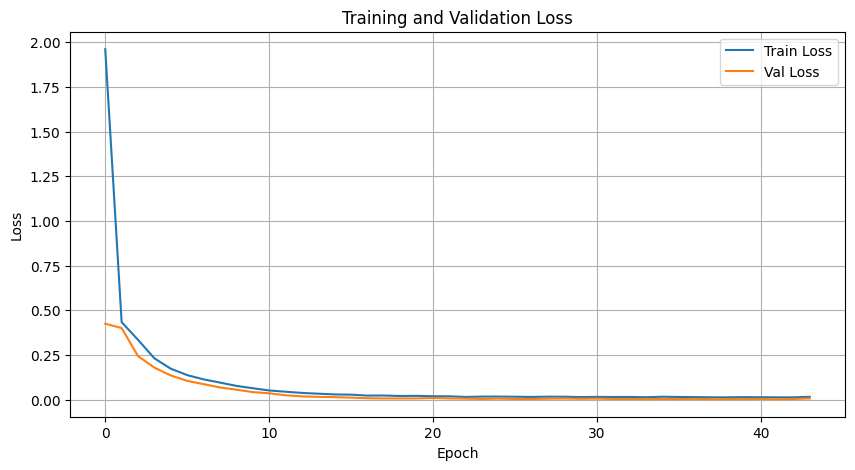

Test Loss: 0.0063


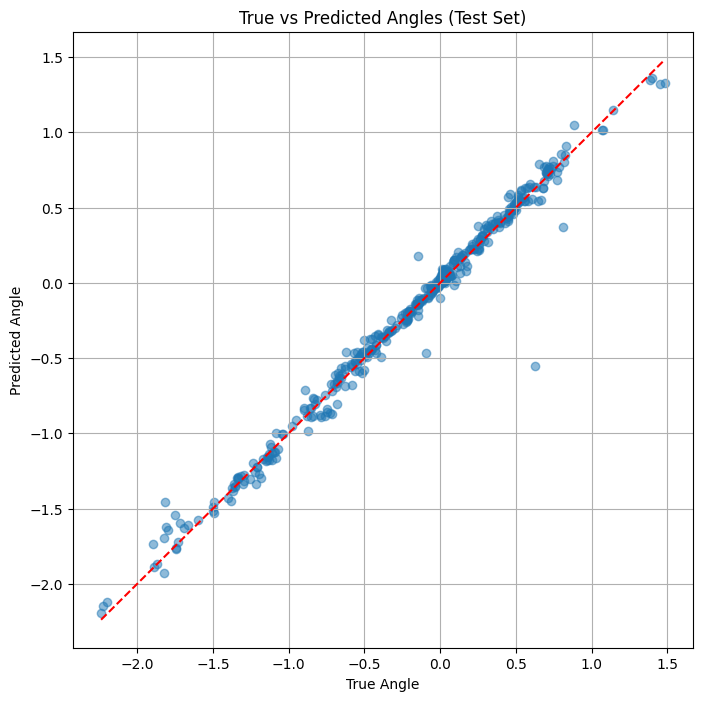

In [81]:
# Load the best model before evaluation
model.load_state_dict(torch.load('controllers/robot/angle.pth'))

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate on test set
model.eval()
test_loss = 0.0
y_pred, y_true = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        test_loss += criterion(outputs, y_batch).item()
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

# Scatter plot of true vs predicted angles

plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("True Angle")
plt.ylabel("Predicted Angle")
plt.title("True vs Predicted Angles (Test Set)")
plt.grid(True)
plt.show()

In [73]:
# @title Plot

def evaluate_and_plot_prediction(y_test, y_pred,n):
    """
    Calculates errors and generates plots to evaluate prediction performance.

    Args:
        y_test (np.ndarray): Array of real values.
        y_pred (np.ndarray): Array of predicted values.
    """
    errors = y_test - y_pred
    y_pred = np.array(y_pred)
    # Calculate metrics
    mae = np.mean(np.abs(errors))
    accuracy = np.mean(np.abs(errors) < 0.2)

    # Plot results
    plt.figure(figsize=(15, 5))

    # Gráfico 1: Predição vs Valor Real
    plt.subplot(131)
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([-2, 2], [-2, 2], 'r--', label='Predição Perfeita')

    plt.title(f'Predição vs Valor Real\ninput size: {n}')
    plt.xlabel('Valor Real')
    plt.ylabel('Predito')
    plt.grid(True)
    plt.legend()

    # Gráfico 2: Distribuição dos Erros
    plt.subplot(132)
    plt.hist(errors, bins=30, alpha=0.7)
    plt.axvline(0, color='r', linestyle='--')
    plt.title(f'Distribuição dos Erros\nMAE: {mae:.4f}')
    plt.xlabel('Erro (Real - Predito)')
    plt.ylabel('Frequência')
    plt.grid(True)

    # Gráfico 3: Valores Reais vs Preditos
    plt.subplot(133)
    sorted_idx = np.argsort(y_test)
    plt.plot(y_test[sorted_idx], label='Valor Real')
    plt.plot(y_pred[sorted_idx], 'r--', alpha=0.7, label='Predição')
    plt.title(f'Comparação Direta\nAcurácia (erro < 0.1): {accuracy:.2%}')
    plt.xlabel('Amostras Ordenadas')
    plt.ylabel('Valor')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Avaliação de desempenho
    print(f"\nErro Médio Absoluto (MAE): {mae:.4f}")
    print(f"Acurácia (erro < 0.1): {accuracy:.2%}")

In [74]:
y_test[0]

np.float64(-0.22094549006151754)

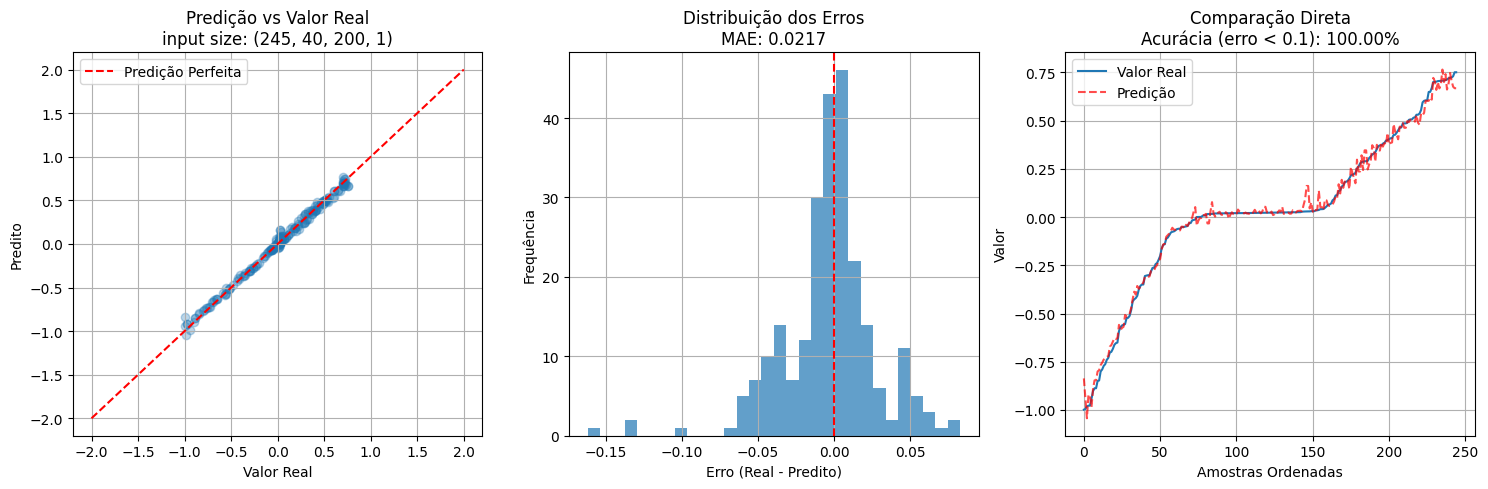


Erro Médio Absoluto (MAE): 0.0217
Acurácia (erro < 0.1): 100.00%


In [75]:
evaluate_and_plot_prediction(y_test, y_pred,X_test.shape)

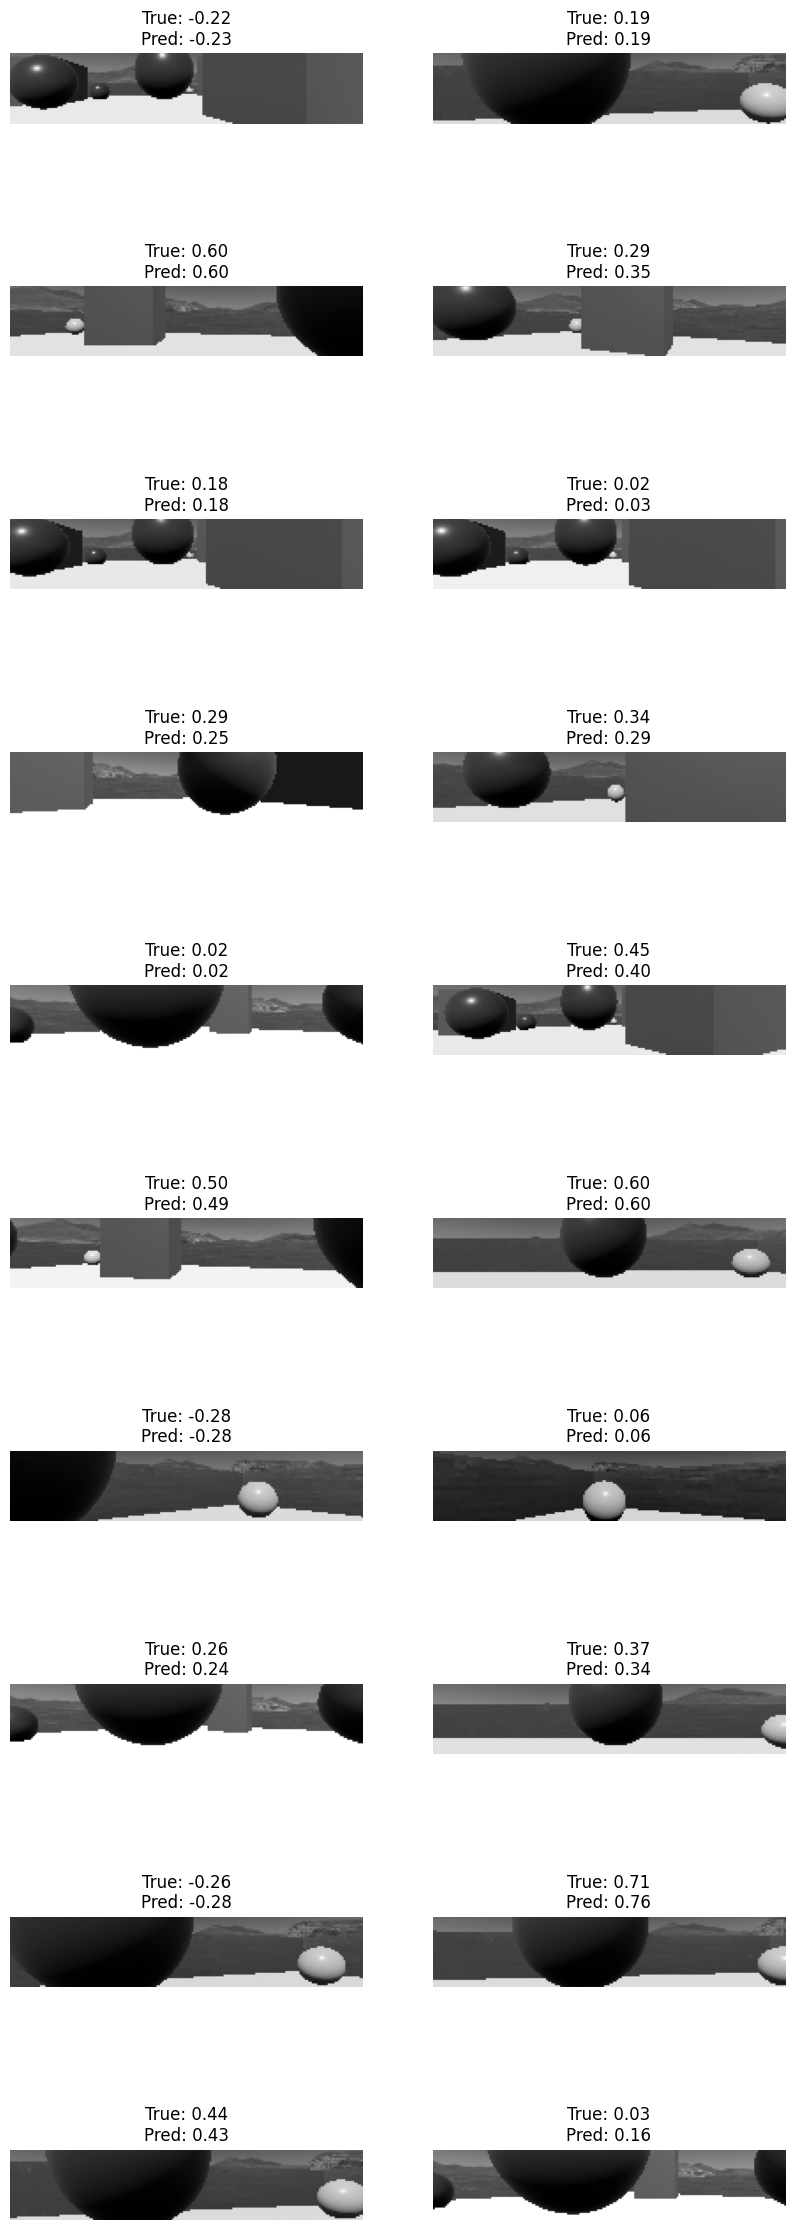

In [76]:
import random  # Visualization of sample predictions
plt.figure(figsize=(10, 60))
n_samples_show = 20
for i in range(n_samples_show):
    plt.subplot(20, 2, i+1)
    img = np.array(X[random.randint(0, len(X))])
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {y_test[i]:.2f}\nPred: {y_pred[i]:.2f}")
    plt.axis('off')
plt.show()

In [77]:
torch.save(model.state_dict(), './controllers/robot/angle.pth')